In [1]:
import numpy as np
import math
import seaborn as sns
import  statsmodels.stats.multitest
import pandas as pd
import matplotlib.pyplot as plt
import pybedtools
import  statsmodels.stats.multitest
import matplotlib.pyplot as plt
import scipy

/home/sabari/dbhavya/miniconda3/envs/KIRP/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import scanpy as sc

/home/sabari/dbhavya/miniconda3/envs/KIRP/lib/python3.7/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [136]:
from statannot import add_stat_annotation

In [159]:
from scipy import stats

In [167]:
from adjustText import adjust_text

# Lung epi vs normal vs meta

### Filter and normalise

In [96]:
adata=sc.read_csv('scripts/dat/lung_meta_epi.csv')

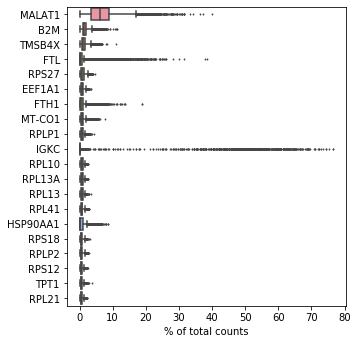

In [97]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [98]:
## filtering cells with less genes and genes withh less cells
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
## Total-count normalize (library-size correct) the data matrix X to 10,000 reads per cell, so that counts become comparable among cells.
sc.pp.normalize_total(adata, target_sum=1e4)
x=pd.DataFrame(data=adata.X, index=adata.obs_names, columns=adata.var_names)

### Average scores

In [112]:
meta=pd.read_csv("scripts/dat/lung_met_epi_annotation.csv",index_col=0)
meta['sample']=meta['Legend']+meta['Cell ID'].astype(str)

In [120]:
logscores=np.log2(np.exp(x))
logscores['sample']=logscores.index
temp=meta.merge(logscores,on='sample')
temp['Immunoproteasome']=temp[['PSMB8','PSMB9','PSMB10']].mean(axis=1)
temp['Const_proteasome']=temp[['PSMB5','PSMB6','PSMB7']].mean(axis=1)
temp2=pd.melt(temp, id_vars=['ID', 'Legend', 'Cell ID', 'CELL_TYPE', 'Meta-Source', 'META_CELL_TYPE', 'PHENOGRAPH_CLASS', 'sample'], value_vars=['Const_proteasome','Immunoproteasome'])

/home/sabari/dbhavya/miniconda3/envs/KIRP/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.


In [134]:
temp2.head()

,ID,Legend,Cell ID,CELL_TYPE,Meta-Source,META_CELL_TYPE,PHENOGRAPH_CLASS,sample,variable,value
0,0,RU653_TUMOR_1AS_UTR,0,Tm,TUMOR,Lymphoid,0_LYMPHOID,RU653_TUMOR_1AS_UTR0,Const_proteasome,0.000000
1,0,RU653_TUMOR_1AS_UTR,2,MACROPHAGE,TUMOR,Myeloid,30_MYELOID_OTHER,RU653_TUMOR_1AS_UTR2,Const_proteasome,1.278390
2,0,RU653_TUMOR_1AS_UTR,3,DENDRITIC,TUMOR,Myeloid,1_MYELOID_OTHER,RU653_TUMOR_1AS_UTR3,Const_proteasome,0.000000
3,0,RU653_TUMOR_1AS_UTR,4,Tm,TUMOR,Lymphoid,0_LYMPHOID,RU653_TUMOR_1AS_UTR4,Const_proteasome,2.471215
4,0,RU653_TUMOR_1AS_UTR,6,Tm,TUMOR,Lymphoid,8_LYMPHOID,RU653_TUMOR_1AS_UTR6,Const_proteasome,0.000000


In [131]:
temp2['CELL_TYPE'].unique()

array(['Tm', 'MACROPHAGE', 'DENDRITIC', 'NKT', 'PERICYTE', 'EPITHELIAL',
       'MAST', 'ENDOTHELIAL', 'MDSC', 'Breg', 'MONOCYTE', 'Treg',
       'DENDRITIC (ACTIVATED)', 'Th', 'FIBROBLAST',
       'PROLIFERATING MESENCHYMAL PROGENITOR', 'NK', 'NEUTROPHIL', 'IG',
       'MICROGLIA/MACROPHAGE'], dtype=object)

In [138]:
box_pairs=[]
for i in temp2['Meta-Source'].unique():
    t1=((i,'Const_proteasome'),(i,'Immunoproteasome'))
    box_pairs.append(t1)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

MET_Const_proteasome v.s. MET_Immunoproteasome: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.098e-188 U_stat=2.151e+06
TUMOR_Const_proteasome v.s. TUMOR_Immunoproteasome: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.355e-40 U_stat=1.404e+06
NOR_Const_proteasome v.s. NOR_Immunoproteasome: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.956e-39 U_stat=3.048e+05


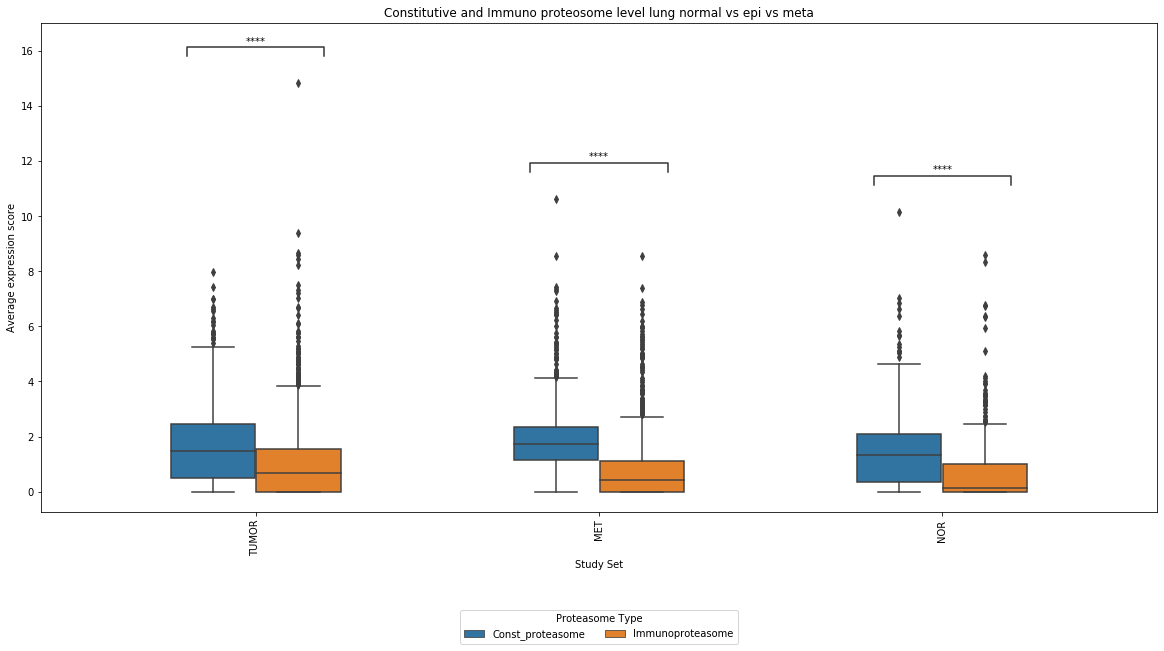

In [139]:
fig, ax=plt.subplots(figsize=(20,9))
res=sns.boxplot(x='Meta-Source',y='value',hue='variable',data=temp2[temp2['CELL_TYPE']=='EPITHELIAL'],width=.5,ax=ax)
add_stat_annotation(res, data=temp2[temp2['CELL_TYPE']=='EPITHELIAL'], x='Meta-Source',y='value',hue='variable' ,box_pairs=box_pairs,test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
plt.xticks(rotation=90)
plt.title('Constitutive and Immuno proteosome level lung normal vs epi vs meta')
handles, labels = ax.get_legend_handles_labels()
ax.legend( handles=handles, labels=labels,loc='upper center', bbox_to_anchor=(0.5, -0.2),fancybox=True, ncol=5,borderaxespad=0.,title='Proteasome Type')
ax.set_xlabel("Study Set")
ax.set_ylabel("Average expression score")
#plt.savefig('CRC_pan_avg_proteasome.svg',bbox_inches = "tight",format='svg')
plt.show()

In [144]:
temp.head()

,ID,Legend,Cell ID,CELL_TYPE,Meta-Source,META_CELL_TYPE,PHENOGRAPH_CLASS,sample,A1BG,A1CF,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,Immunoproteasome,Const_proteasome
0,0,RU653_TUMOR_1AS_UTR,0,Tm,TUMOR,Lymphoid,0_LYMPHOID,RU653_TUMOR_1AS_UTR0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
1,0,RU653_TUMOR_1AS_UTR,2,MACROPHAGE,TUMOR,Myeloid,30_MYELOID_OTHER,RU653_TUMOR_1AS_UTR2,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,1.917585,0.0,0.0,0.319598,1.278390
2,0,RU653_TUMOR_1AS_UTR,3,DENDRITIC,TUMOR,Myeloid,1_MYELOID_OTHER,RU653_TUMOR_1AS_UTR3,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.873725,0.000000
3,0,RU653_TUMOR_1AS_UTR,4,Tm,TUMOR,Lymphoid,0_LYMPHOID,RU653_TUMOR_1AS_UTR4,14.827288,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,2.471215,2.471215
4,0,RU653_TUMOR_1AS_UTR,6,Tm,TUMOR,Lymphoid,8_LYMPHOID,RU653_TUMOR_1AS_UTR6,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,9.221445,0.0,0.0,3.073815,0.000000


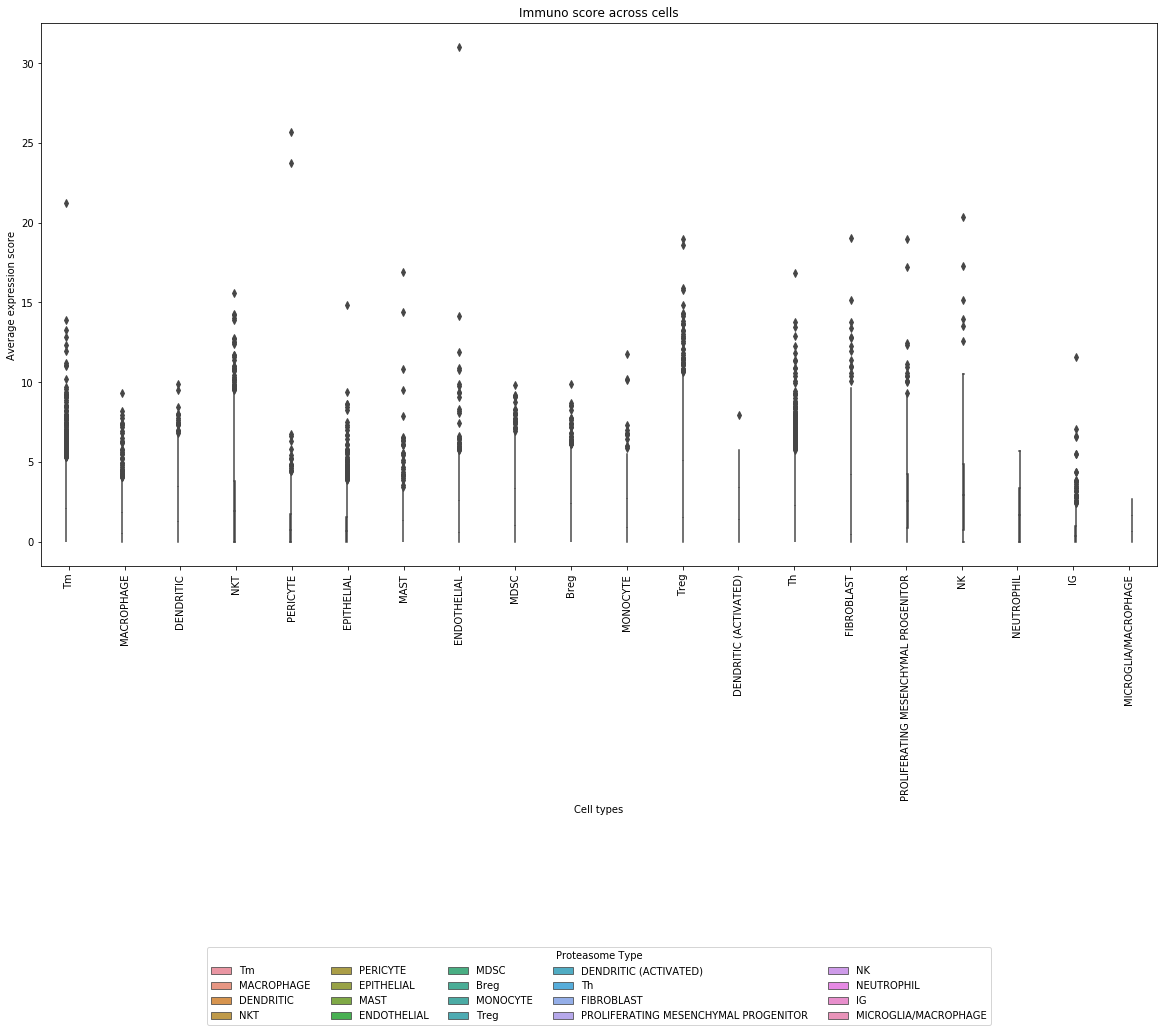

In [154]:
### all cell from epi tissue
fig, ax=plt.subplots(figsize=(20,10))
res=sns.boxplot(x='CELL_TYPE',y='Immunoproteasome',hue='CELL_TYPE',data=temp[temp['Meta-Source']=='TUMOR'],width=.1,ax=ax)
plt.xticks(rotation=90)
plt.title('Immuno score across cells')
handles, labels = ax.get_legend_handles_labels()
ax.legend( handles=handles, labels=labels,loc='upper center', bbox_to_anchor=(0.5, -0.7),fancybox=True, ncol=5,borderaxespad=0.,title='Proteasome Type')
ax.set_xlabel("Cell types")
ax.set_ylabel("Average expression score")
#plt.savefig('Cohort2_cells.svg',bbox_inches = "tight",format='svg')
plt.show()

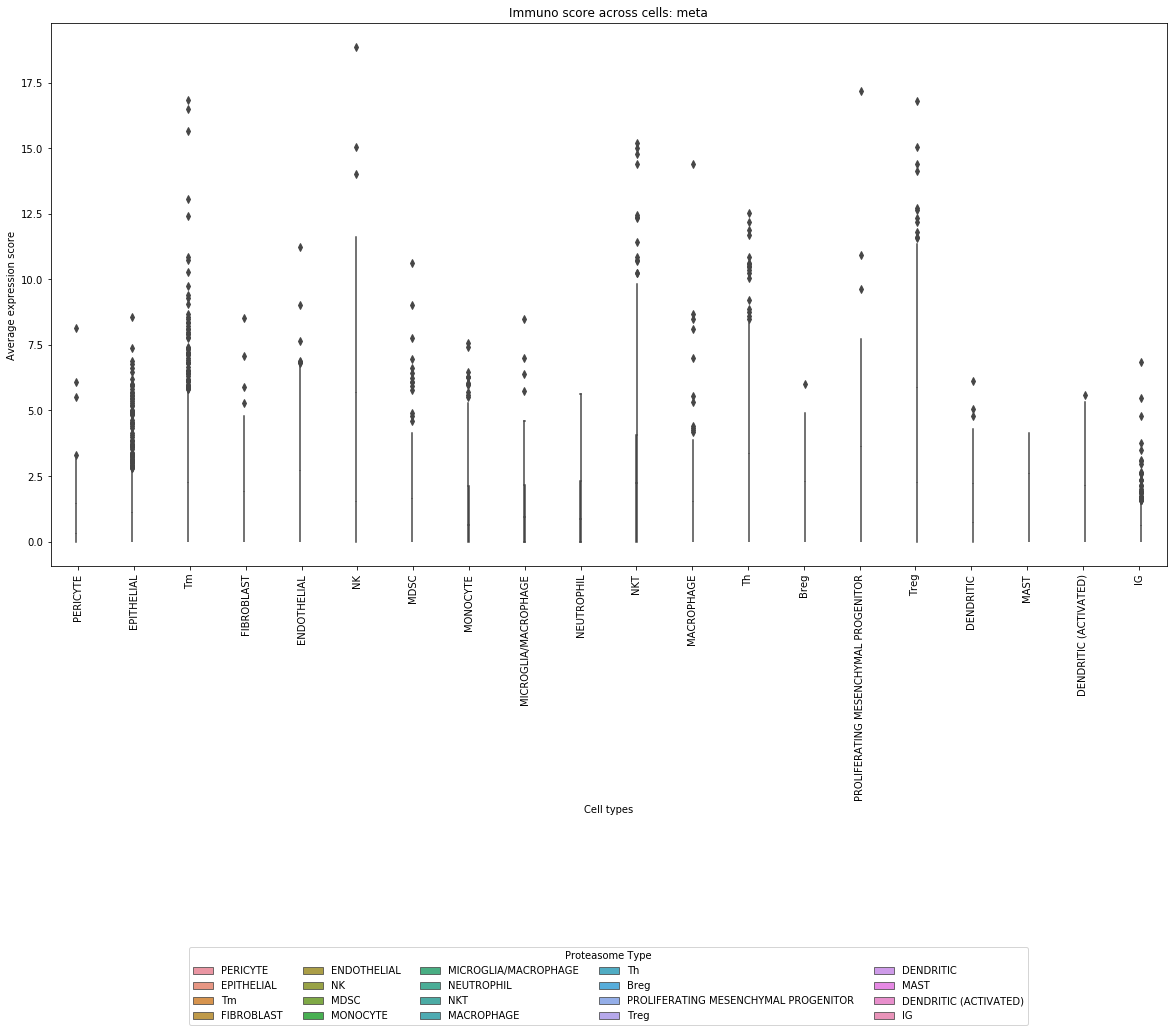

In [155]:
### all cell from epi tissue
fig, ax=plt.subplots(figsize=(20,10))
res=sns.boxplot(x='CELL_TYPE',y='Immunoproteasome',hue='CELL_TYPE',data=temp[temp['Meta-Source']=='MET'],width=.1,ax=ax)
plt.xticks(rotation=90)
plt.title('Immuno score across cells: meta')
handles, labels = ax.get_legend_handles_labels()
ax.legend( handles=handles, labels=labels,loc='upper center', bbox_to_anchor=(0.5, -0.7),fancybox=True, ncol=5,borderaxespad=0.,title='Proteasome Type')
ax.set_xlabel("Cell types")
ax.set_ylabel("Average expression score")
#plt.savefig('Cohort2_cells.svg',bbox_inches = "tight",format='svg')
plt.show()

In [185]:
f1=pd.DataFrame(index=temp['CELL_TYPE'].unique(),columns=['corr','num','sp'])
g=1
for i in temp['CELL_TYPE'].unique():
    x=np.array(temp['Immunoproteasome'][(temp['CELL_TYPE']==i)&(temp['Meta-Source']=='MET')])
    y=np.array(temp['Const_proteasome'][(temp['CELL_TYPE']==i)&(temp['Meta-Source']=='MET')])
    f1.loc[i,'corr']=np.corrcoef(x,y)[0,1]
    c,p=stats.spearmanr(x,y)
    f1.loc[i,'sp']=c
    f1.loc[i,'num']=g
    g=g+1
    f1['st']='MET'

In [186]:
f2=pd.DataFrame(index=temp['CELL_TYPE'].unique(),columns=['corr','num','sp'])
g=1
for i in temp['CELL_TYPE'].unique():
    x=np.array(temp['Immunoproteasome'][(temp['CELL_TYPE']==i)&(temp['Meta-Source']=='TUMOR')])
    y=np.array(temp['Const_proteasome'][(temp['CELL_TYPE']==i)&(temp['Meta-Source']=='TUMOR')])
    f2.loc[i,'corr']=np.corrcoef(x,y)[0,1]
    c,p=stats.spearmanr(x,y)
    f2.loc[i,'sp']=c
    f2.loc[i,'num']=g
    g=g+1
    f2['st']='TUMOR'

In [187]:
f1['l']=f1.index
f2['l']=' '
f1=pd.concat([f1,f2])

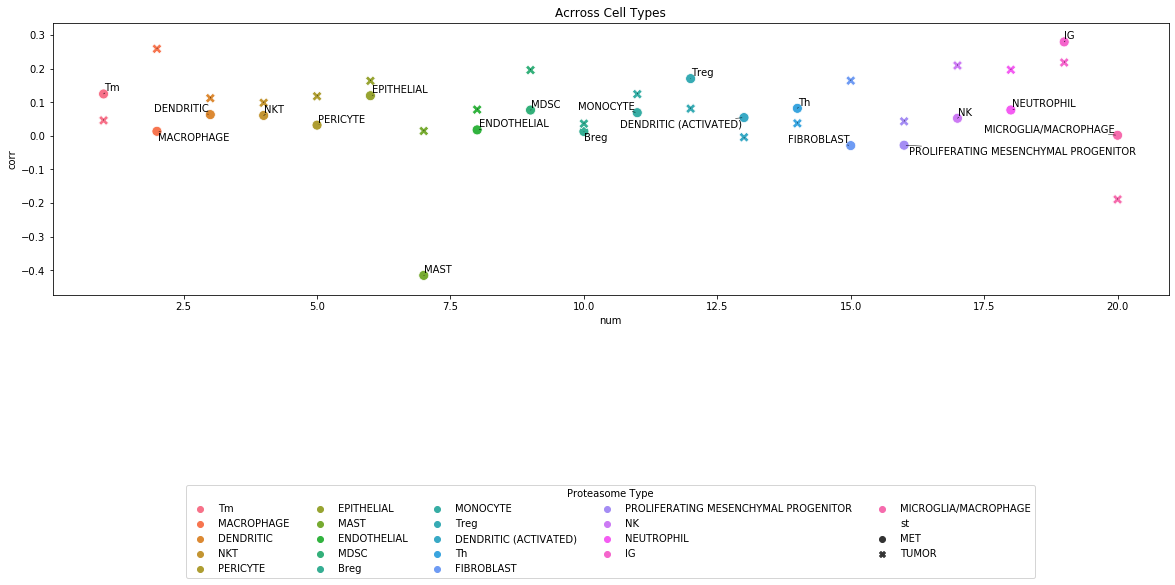

In [189]:
fig, ax = plt.subplots(figsize=(20,5))  
sns.scatterplot(data=f1, x="num", y="corr",hue=f1.index,ax=ax,s=100,style="st").set_title('Acrross Cell Types')
handles, labels = ax.get_legend_handles_labels()
ax.legend( handles=handles, labels=labels,loc='upper center', bbox_to_anchor=(0.5, -0.7),fancybox=True, ncol=5,borderaxespad=0.,title='Proteasome Type')

text=[]
for (x,y,label) in np.array(f1[['num', 'corr','l']]):
    text.append(plt.text(x,y,label,zorder=8,size=10))
adjust_text(text, arrowprops=dict(arrowstyle='-', color='black',lw=0.5))
#plt.savefig('Corr_2.svg',bbox_inches = "tight",format='svg')
plt.show()

# TNBC STUDY

In [191]:
adata = sc.read_10x_mtx(
    'scripts/dat/counts_matrix/',  
    var_names='gene_symbols',                
    cache=True)

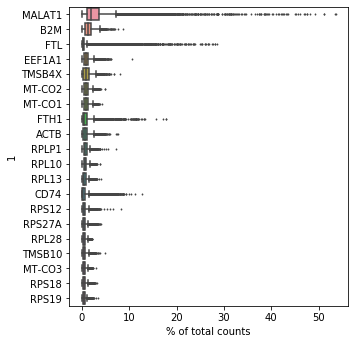

In [192]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [193]:
## filtering cells with less genes and genes withh less cells
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
## Total-count normalize (library-size correct) the data matrix X to 10,000 reads per cell, so that counts become comparable among cells.
sc.pp.normalize_total(adata, target_sum=1e4)


Trying to set attribute `.obs` of view, making a copy.


In [ ]:
x=pd.DataFrame.sparse.from_spmatrix(data=adata.X, index=adata.obs_names, columns=adata.var_names).T

In [210]:
meta=pd.read_csv('scripts/dat/Wu_EMBO_metadata.csv')
meta.drop(0,inplace=True)

In [216]:
meta.head()

,NAME,orig.ident,percent.mito,patientID,nCount_RNA,nFeature_RNA,celltype_final
1,CID44041_AAACCTGAGACAAAGG,CID44041,0.014350453,P1,1324,720,iCAFs
2,CID44041_AAACCTGAGCGTAGTG,CID44041,0.026958525,P1,4340,1700,iCAFs
3,CID44041_AAACGGGAGAGAGCTC,CID44041,0.051685393,P1,2225,537,iCAFs
4,CID44041_AAAGATGTCTCAAGTG,CID44041,0.021001616,P1,1238,730,iCAFs
5,CID44041_AAAGCAACAAATACAG,CID44041,0.03075944,P1,4714,1786,iCAFs


In [217]:
meta.columns

Index(['NAME', 'orig.ident', 'percent.mito', 'patientID', 'nCount_RNA',
       'nFeature_RNA', 'celltype_final'],
      dtype='object')

In [219]:
logscores=np.log2(np.exp(x))
logscores['NAME']=logscores.index
temp=meta.merge(logscores,on='NAME')
temp['Immunoproteasome']=temp[['PSMB8','PSMB9','PSMB10']].mean(axis=1)
temp['Const_proteasome']=temp[['PSMB5','PSMB6','PSMB7']].mean(axis=1)
temp2=pd.melt(temp, id_vars=['NAME','patientID','celltype_final'], value_vars=['Const_proteasome','Immunoproteasome'])

In [221]:
temp2['celltype_final'].unique()

array(['iCAFs', 'myCAFs', 'Plasma_Cells', 'Epithelial_Basal',
       'Endothelial', 'Myeloid', 'T_cells_unassigned', 'CD8+ T-cells',
       'NKT cells', 'NK cells', 'T-cells Cycling', 'CD4+ T-cells',
       'T-Regs', 'Tfh cells', 'dPVL', 'imPVL', 'B_Cells', 'Myoepithelial',
       'Epithelial_Basal_Cycling', 'Epithelial_Luminal_Mature'],
      dtype=object)

In [231]:
box_pairs=[('Const_proteasome','Immunoproteasome')]

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Const_proteasome v.s. Immunoproteasome: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.769e-42 U_stat=9.808e+06


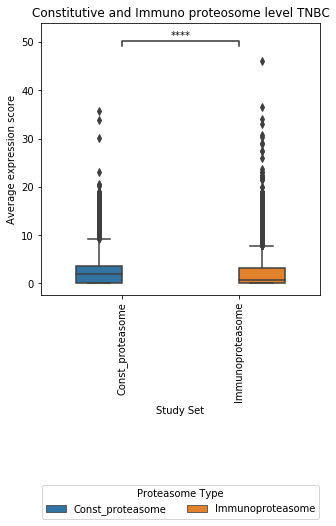

In [233]:
fig, ax=plt.subplots(figsize=(5,5))
res=sns.boxplot(x='variable',y='value',hue='variable',data=temp2[temp2['celltype_final']=='Epithelial_Basal'],ax=ax)
add_stat_annotation(res, data=temp2[temp2['celltype_final']=='Epithelial_Basal'], x='variable',y='value' ,box_pairs=box_pairs,test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
plt.xticks(rotation=90)
plt.title('Constitutive and Immuno proteosome level TNBC')
handles, labels = ax.get_legend_handles_labels()
ax.legend( handles=handles, labels=labels,loc='upper center', bbox_to_anchor=(0.5, -0.7),fancybox=True, ncol=5,borderaxespad=0.,title='Proteasome Type')
ax.set_xlabel("Study Set")
ax.set_ylabel("Average expression score")
#plt.savefig('CRC_pan_avg_proteasome.svg',bbox_inches = "tight",format='svg')
plt.show()

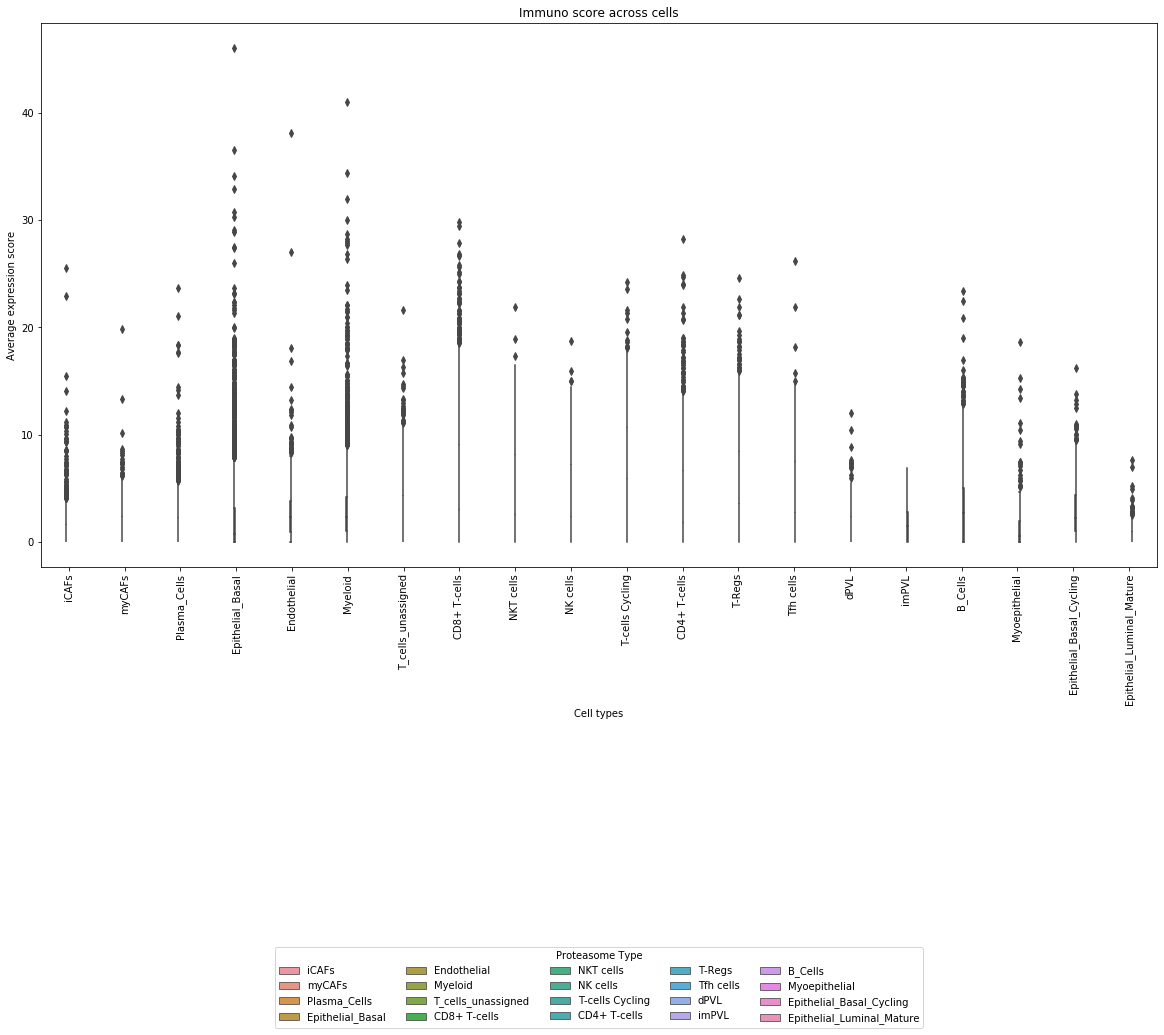

In [234]:
### all cell from epi tissue
fig, ax=plt.subplots(figsize=(20,10))
res=sns.boxplot(x='celltype_final',y='Immunoproteasome',hue='celltype_final',data=temp,width=.1,ax=ax)
plt.xticks(rotation=90)
plt.title('Immuno score across cells')
handles, labels = ax.get_legend_handles_labels()
ax.legend( handles=handles, labels=labels,loc='upper center', bbox_to_anchor=(0.5, -0.7),fancybox=True, ncol=5,borderaxespad=0.,title='Proteasome Type')
ax.set_xlabel("Cell types")
ax.set_ylabel("Average expression score")
#plt.savefig('Cohort2_cells.svg',bbox_inches = "tight",format='svg')
plt.show()

In [237]:
f1=pd.DataFrame(index=temp['celltype_final'].unique(),columns=['corr','num','sp'])
g=1
for i in temp['celltype_final'].unique():
    x=np.array(temp['Immunoproteasome'][(temp['celltype_final']==i)])
    y=np.array(temp['Const_proteasome'][(temp['celltype_final']==i)])
    f1.loc[i,'corr']=np.corrcoef(x,y)[0,1]
    c,p=stats.spearmanr(x,y)
    f1.loc[i,'sp']=c
    f1.loc[i,'num']=g
    g=g+1
    f1['st']='TNBC'

f1['l']=f1.index

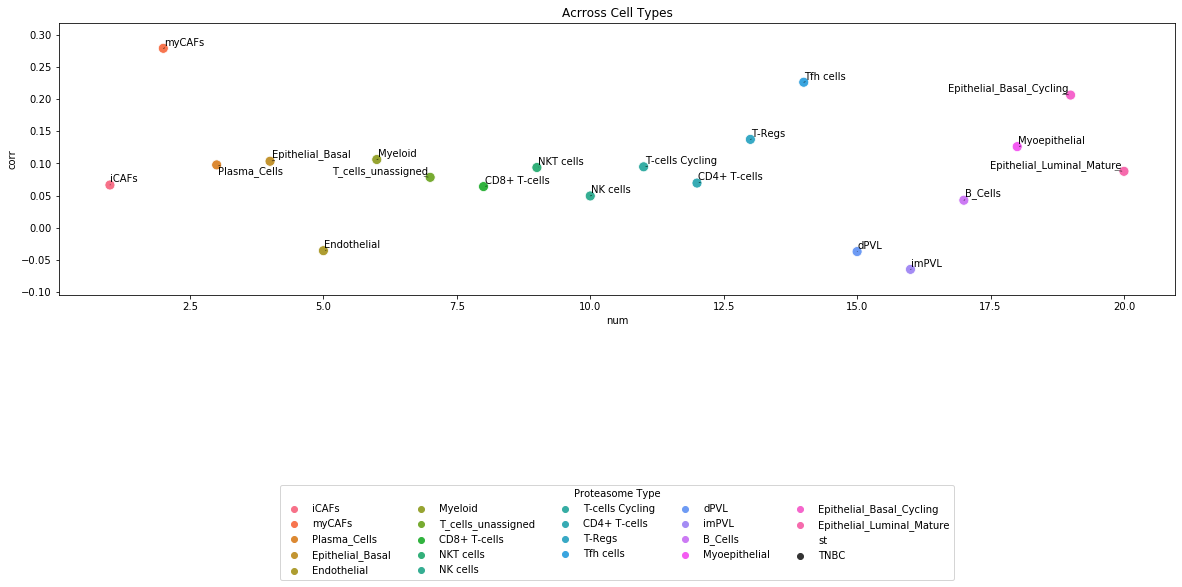

In [238]:
fig, ax = plt.subplots(figsize=(20,5))  
sns.scatterplot(data=f1, x="num", y="corr",hue=f1.index,ax=ax,s=100,style="st").set_title('Acrross Cell Types')
handles, labels = ax.get_legend_handles_labels()
ax.legend( handles=handles, labels=labels,loc='upper center', bbox_to_anchor=(0.5, -0.7),fancybox=True, ncol=5,borderaxespad=0.,title='Proteasome Type')

text=[]
for (x,y,label) in np.array(f1[['num', 'corr','l']]):
    text.append(plt.text(x,y,label,zorder=8,size=10))
adjust_text(text, arrowprops=dict(arrowstyle='-', color='black',lw=0.5))
#plt.savefig('Corr_2.svg',bbox_inches = "tight",format='svg')
plt.show()

# Ovarian

In [303]:
x=pd.read_csv("scripts/dat/GSE146026_Izar_HGSOC_ascites_10x_log.tsv.gz",sep='\t',skiprows=1,header=0,index_col=0)
x=x.T
x.drop(['patient','time','sample_ID','clst','TSNE_x','TSNE_y'],axis=1,inplace=True)

In [309]:
x.to_csv('scripts/dat/ovariant_sc.csv')

In [311]:
adata=sc.read_csv('scripts/dat/ovariant_sc.csv')

In [312]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/sabari/dbhavya/miniconda3/envs/KIRP/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../../../../../../home/sabari/dbhavya/miniconda3/envs/KIRP/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/home/sabari/dbhavya/miniconda3/envs/KIRP/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel

In [315]:
sc.tl.leiden(adata)
sc.tl.umap(adata)

running Leiden clustering
    finished (0:00:01)


ranking genes
    finished (0:00:23)


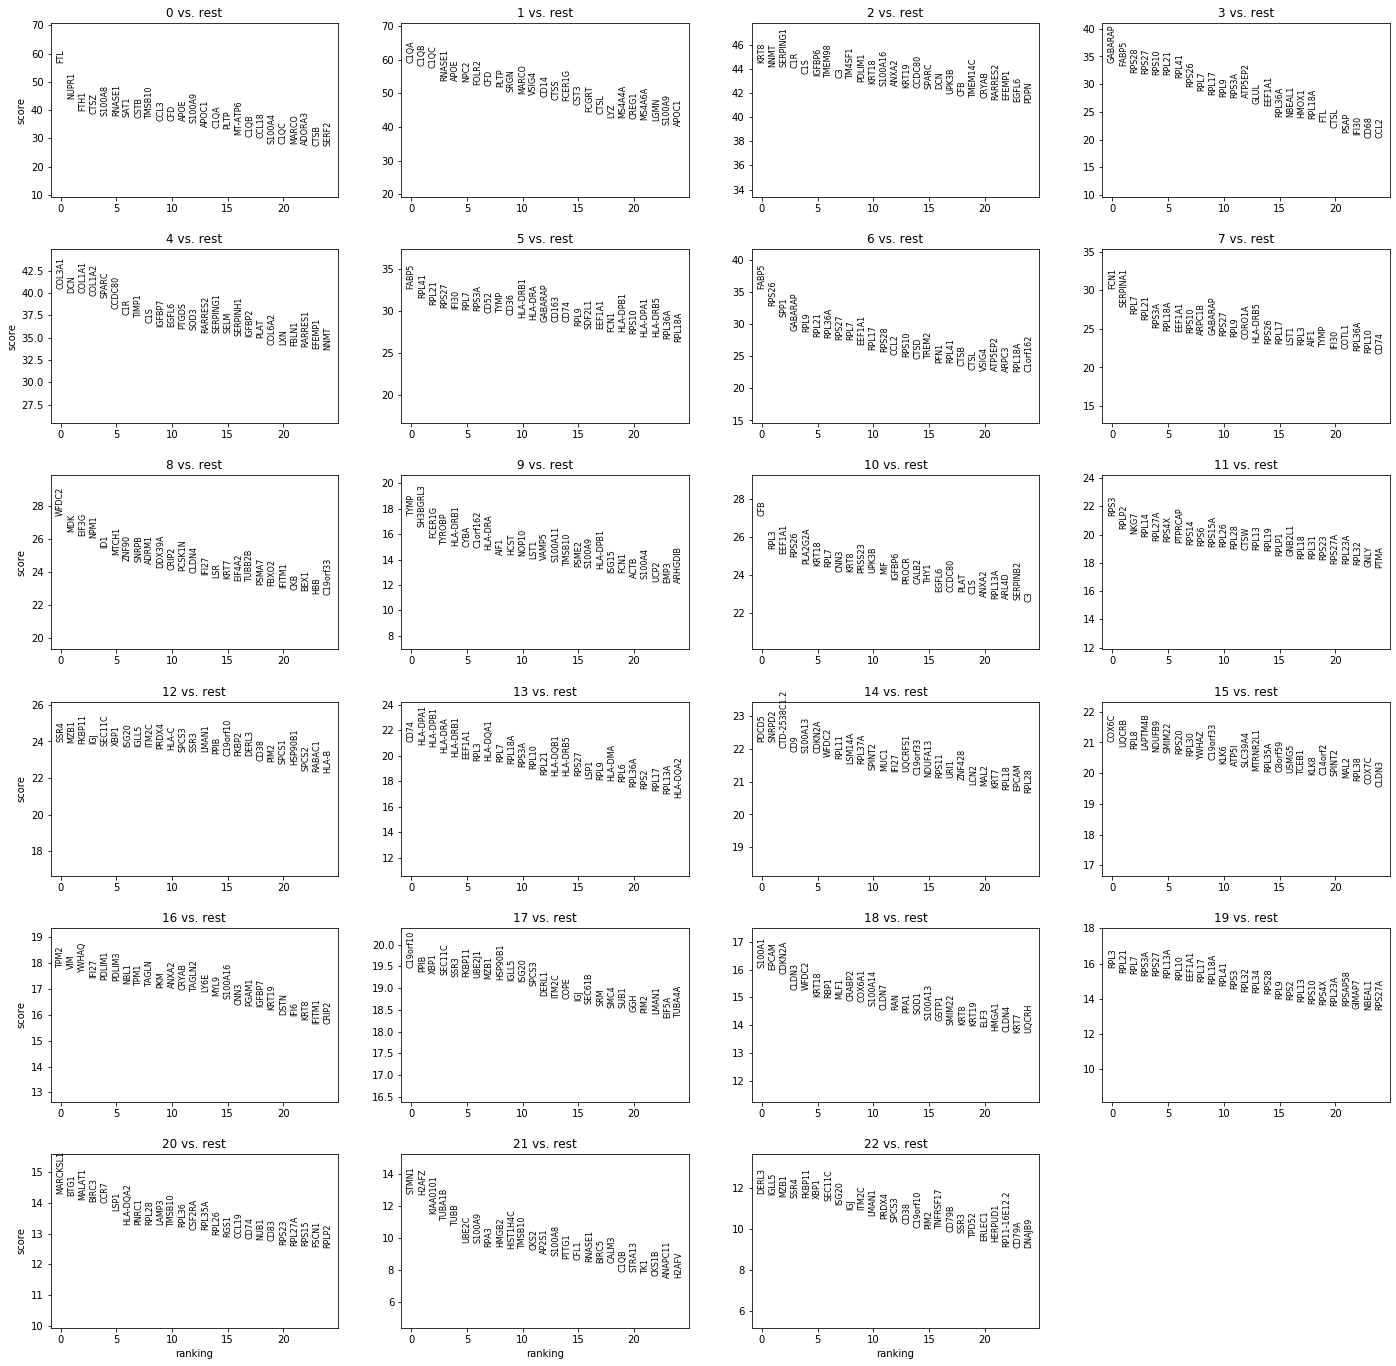

In [316]:
sc.settings.verbosity = 2  # reduce the verbosity
#The result of a Wilcoxon rank-sum (Mann-Whitney-U) 
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [321]:
#Get a table with the scores and groups.
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,...,18_n,18_p,19_n,19_p,20_n,20_p,21_n,21_p,22_n,22_p
0,FTL,0.0,C1QA,0.0,KRT8,0.0,GABARAP,6.271409e-250,COL3A1,0.0,...,S100A1,4.755000e-58,RPL3,5.848405e-56,MARCKSL1,2.306804e-46,STMN1,2.641552e-37,DERL3,1.230216e-31
1,NUPR1,0.0,C1QB,0.0,NNMT,0.0,FABP5,3.758315e-243,DCN,0.0,...,EPCAM,1.673394e-57,RPL21,8.477714e-54,BTG1,6.058940e-46,H2AFZ,3.904499e-37,IGLL5,2.546204e-31
2,FTH1,0.0,C1QC,0.0,SERPING1,0.0,RPS28,3.090421e-224,COL1A1,0.0,...,CDKN2A,1.386818e-56,RPL7,1.331443e-53,MALAT1,3.422404e-45,KIAA0101,1.185655e-30,MZB1,8.131375e-31
3,CTSZ,0.0,RNASE1,0.0,C1R,0.0,RPS27,1.924423e-223,COL1A2,0.0,...,CLDN3,1.076032e-52,RPS3A,5.140784e-53,BIRC3,7.995180e-45,TUBA1B,1.180360e-28,SSR4,1.158225e-30
4,S100A8,0.0,APOE,0.0,C1S,0.0,RPS10,1.901985e-220,SPARC,0.0,...,WFDC2,1.155221e-52,RPS27,5.397302e-53,CCR7,1.619026e-44,TUBB,5.407711e-27,FKBP11,1.355105e-30


In [342]:
adata.obs

,leiden
10x_3288_t1_AAACATACCTTCCG-1,0
10x_3288_t1_AAACATACTCCTAT-1,1
10x_3288_t1_AAACATTGAACTGC-1,1
10x_3288_t1_AAACATTGCTGACA-1,4
10x_3288_t1_AAACCGTGACAGTC-1,2
...,...
10x_3250_t2_TTGGGAACAAAGCA-1,8
10x_3250_t2_TTGGTACTGTTACG-1,16
10x_3250_t2_TTGTCATGTGCTAG-1,8
10x_3250_t2_TTTCAGTGTTTGCT-1,8


In [322]:
dat = pd.DataFrame({group + '_' + key[:1]: result[key][group] for group in groups for key in ['names', 'logfoldchanges','scores','pvals']})
dat.to_csv("scanpy_ov_marker.csv")

# Colon

In [273]:
st=[]

In [268]:
counts=pd.read_csv("/data/incubator/bhavya/projects/Immunoproteosome/RNA-seq/KUL3_PSMB_sel.tsv",sep='\t',index_col=0, compression='infer')
sample=pd.read_csv("/data/incubator/bhavya/projects/Immunoproteosome/RNA-seq/GSE144735_processed_KUL3_CRC_10X_annotation.txt.gz",sep='\t')

In [269]:
logscores=np.log2(np.exp(counts))
logscores=logscores.T
logscores['Index']=logscores.index
logscores.index.name=None
temp=sample.merge(logscores,on='Index')
temp['Region']=temp['Sample'].str.slice(-1)
temp=sample.merge(logscores,on='Index')
temp['Region']=temp['Sample'].str.slice(-1)
belg=temp[['Index', 'Patient', 'Class', 'Sample', 'Cell_type', 'Cell_subtype','Region']]
belg['Const_proteasome']=temp[['PSMB5','PSMB6','PSMB7']].mean(axis=1)
belg['Immunoproteasome']=temp[['PSMB8','PSMB9','PSMB10']].mean(axis=1)

temp2=pd.melt(belg, id_vars=['Index','Cell_type','Class','Region','Patient','Sample'], value_vars=['Const_proteasome','Immunoproteasome'])
temp2['Study']='Cohort 1'

/home/sabari/dbhavya/miniconda3/envs/KIRP/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/sabari/dbhavya/miniconda3/envs/KIRP/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [274]:
st.append(temp2[['variable', 'value', 'Study','Cell_type','Region']][(temp2['Cell_type']=='Epithelial cells')])

In [275]:
#Korean study 23 samples
counts=pd.read_csv("/data/incubator/bhavya/projects/Immunoproteosome/RNA-seq/GSE132465_GEO_processed_CRC_10X_selcted.tsv",sep='\t',index_col=0, compression='infer')
sample=pd.read_csv("/data/incubator/bhavya/projects/Immunoproteosome/RNA-seq/GSE132465_GEO_processed_CRC_10X_cell_annotation.txt.gz",sep='\t',index_col=0, compression='infer')


In [276]:
logscores=np.log2(np.exp(counts))
logscores=logscores.T
logscores['Index']=logscores.index
logscores.index.name=None
temp=sample.merge(logscores,on='Index')
temp['Region']=temp['Sample'].str.slice(-1)
temp=sample.merge(logscores,on='Index')
temp['Region']=temp['Sample'].str.slice(-1)

In [277]:
kor=temp[['Index', 'Patient', 'Class', 'Sample', 'Cell_type', 'Cell_subtype','Region']]
kor['Immunoproteasome']=temp[['PSMB8','PSMB9','PSMB10']].mean(axis=1)
kor['Const_proteasome']=temp[['PSMB5','PSMB6','PSMB7']].mean(axis=1)
temp2=pd.melt(kor, id_vars=['Index','Cell_type','Class','Region','Patient','Sample'], value_vars=['Const_proteasome','Immunoproteasome'])
temp2['Study']='Cohort 2'

/home/sabari/dbhavya/miniconda3/envs/KIRP/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/sabari/dbhavya/miniconda3/envs/KIRP/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [279]:
st.append(temp2[['variable', 'value', 'Study','Cell_type','Region']][(temp2['Cell_type']=='Epithelial cells')])

In [281]:
st=pd.concat(st)

In [282]:
box_pairs=[]
for i in st['Study'].unique():
    t1=((i,'Const_proteasome'),(i,'Immunoproteasome'))
    box_pairs.append(t1)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Cohort 2_Const_proteasome v.s. Cohort 2_Immunoproteasome: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=0.000e+00 U_stat=2.443e+08
Cohort 1_Const_proteasome v.s. Cohort 1_Immunoproteasome: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.626e-192 U_stat=2.483e+07


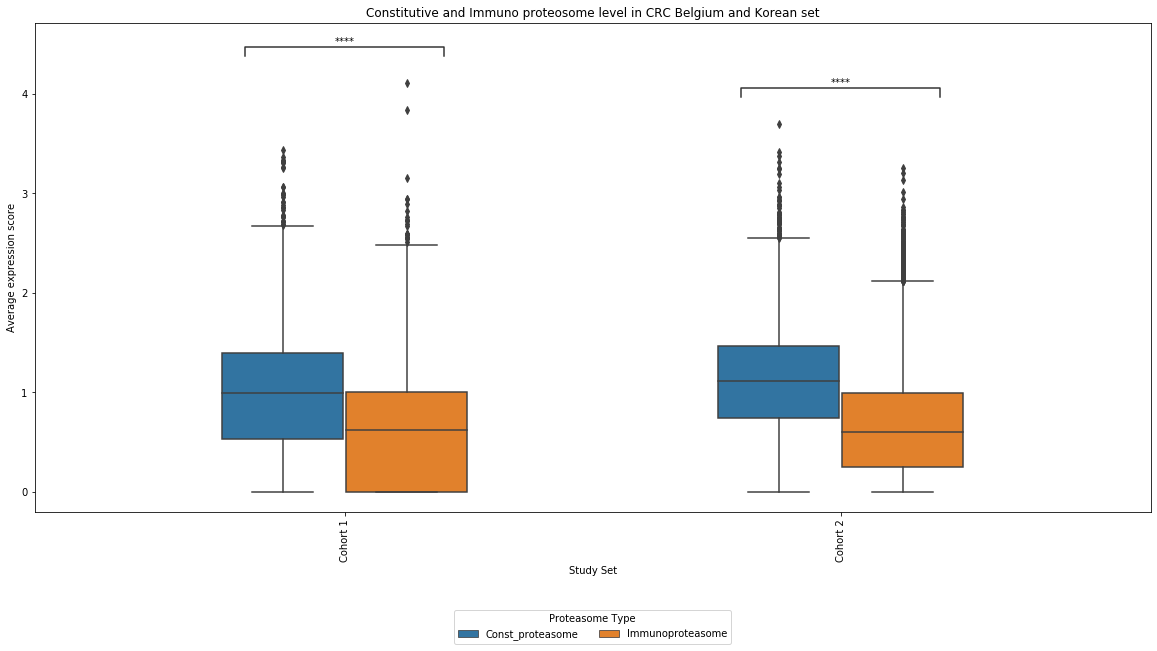

In [283]:
fig, ax=plt.subplots(figsize=(20,9))
res=sns.boxplot(x='Study',y='value',hue='variable',data=st,width=.5,ax=ax)
add_stat_annotation(res, data=st, x='Study',y='value',hue='variable' ,box_pairs=box_pairs,test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
plt.xticks(rotation=90)
plt.title('Constitutive and Immuno proteosome level in CRC Belgium and Korean set')
handles, labels = ax.get_legend_handles_labels()
ax.legend( handles=handles, labels=labels,loc='upper center', bbox_to_anchor=(0.5, -0.2),fancybox=True, ncol=5,borderaxespad=0.,title='Proteasome Type')
ax.set_xlabel("Study Set")
ax.set_ylabel("Average expression score")
#plt.savefig('CRC_pan_avg_proteasome.svg',bbox_inches = "tight",format='svg')
plt.show()

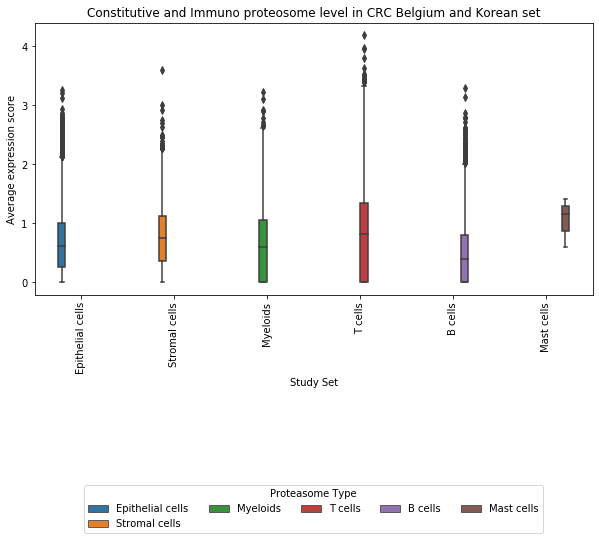

In [285]:
fig, ax=plt.subplots(figsize=(10,5))
res=sns.boxplot(x='Cell_type',y='Immunoproteasome',hue='Cell_type',data=kor[kor['Region']!='N'],width=.5,ax=ax)
#add_stat_annotation(res, data=st, x='Study',y='value',hue='variable' ,box_pairs=box_pairs,test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
plt.xticks(rotation=90)
plt.title('Constitutive and Immuno proteosome level in CRC Belgium and Korean set')
handles, labels = ax.get_legend_handles_labels()
ax.legend( handles=handles, labels=labels,loc='upper center', bbox_to_anchor=(0.5, -0.7),fancybox=True, ncol=5,borderaxespad=0.,title='Proteasome Type')
ax.set_xlabel("Study Set")
ax.set_ylabel("Average expression score")
#plt.savefig('Cohort2_cells.svg',bbox_inches = "tight",format='svg')
plt.show()

In [290]:
box_pairs=[]
for i in st['variable'].unique():
    t1=((i,'T'),(i,'B'))
    box_pairs.append(t1)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Const_proteasome_T v.s. Const_proteasome_B: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.768e-06 U_stat=2.860e+06
Immunoproteasome_T v.s. Immunoproteasome_B: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.950e-05 U_stat=2.904e+06


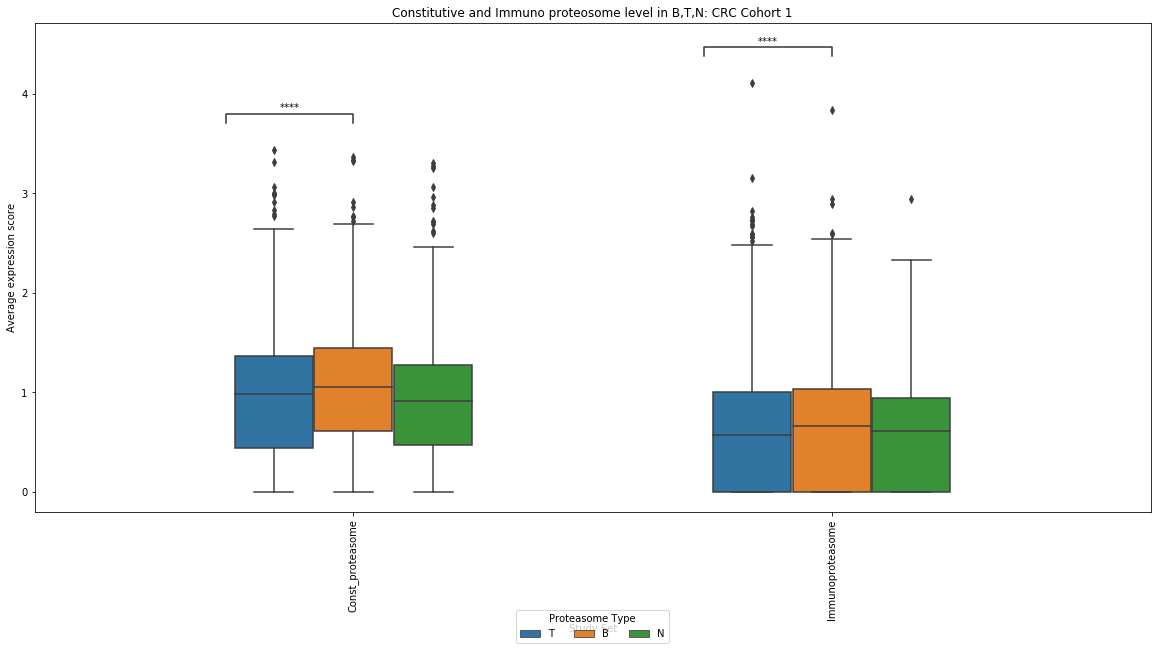

In [292]:
fig, ax=plt.subplots(figsize=(20,9))
res=sns.boxplot(x='variable',y='value',hue='Region',data=st[(st['Study']=='Cohort 1')&(st['Cell_type']=='Epithelial cells')],width=.5,ax=ax)
add_stat_annotation(res, data=st[st['Study']=='Cohort 1'], x='variable',y='value',hue='Region' ,box_pairs=box_pairs,test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
plt.xticks(rotation=90)
plt.title('Constitutive and Immuno proteosome level in B,T,N: CRC Cohort 1')
handles, labels = ax.get_legend_handles_labels()
ax.legend( handles=handles, labels=labels,loc='upper center', bbox_to_anchor=(0.5, -0.2),fancybox=True, ncol=5,borderaxespad=0.,title='Proteasome Type')
ax.set_xlabel("Study Set")
ax.set_ylabel("Average expression score")
#plt.savefig('CRC_border_2_proteasome.svg',bbox_inches = "tight",format='svg')
plt.show()

In [293]:
f1=pd.DataFrame(index=kor['Cell_type'].unique(),columns=['corr','num','sp'])
g=1
for i in kor['Cell_type'].unique():
    x=np.array(kor['Immunoproteasome'][(kor['Cell_type']==i)&(kor['Region']!='N')])
    y=np.array(kor['Const_proteasome'][(kor['Cell_type']==i)&(kor['Region']!='N')])
    f1.loc[i,'corr']=np.corrcoef(x,y)[0,1]
    c,p=stats.spearmanr(x,y)
    f1.loc[i,'sp']=c
    f1.loc[i,'num']=g
    g=g+1
    f1['st']='kor'
    
f2=pd.DataFrame(index=kor['Cell_type'].unique(),columns=['corr','num','sp'])
g=1
for i in belg['Cell_type'].unique():
    x=np.array(belg['Immunoproteasome'][(belg['Cell_type']==i)&(belg['Region']!='N')])
    y=np.array(belg['Const_proteasome'][(belg['Cell_type']==i)&(belg['Region']!='N')])
    f2.loc[i,'corr']=np.corrcoef(x,y)[0,1]
    c,p=stats.spearmanr(x,y)
    f2.loc[i,'sp']=c
    f2.loc[i,'num']=g
    g=g+1
    f2['st']='bel'
f1=pd.concat([f1,f2])
f1['l']=f1.index

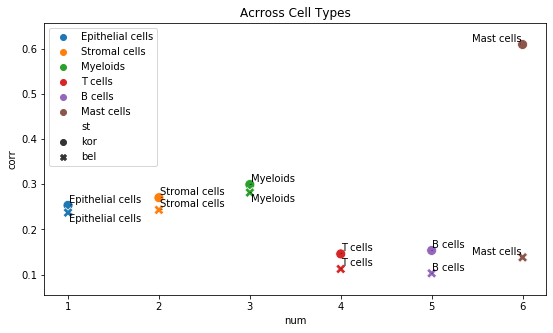

In [294]:
fig, ax = plt.subplots(figsize=(9,5))  
sns.scatterplot(data=f1, x="num", y="corr",hue=f1.index,ax=ax,s=100,style="st").set_title('Acrross Cell Types')
#ax.get_legend().remove()
text=[]
for (x,y,label) in np.array(f1[['num', 'corr','l']]):
    text.append(plt.text(x,y,label,zorder=8,size=10))
adjust_text(text, arrowprops=dict(arrowstyle='-', color='black',lw=0.5))
#plt.savefig('Corr_2.svg',bbox_inches = "tight",format='svg')
plt.show()

# Pan-Cancer Study

In [295]:
pst=[]
for c in ['Lung','Ovarian','Breast','Colorectal']:
    counts=pd.read_csv("/data/incubator/bhavya/projects/Immunoproteosome/RNA-seq/pan/"+c+"_scaled_filtered_PSM.tsv",sep='\t',index_col=0, compression='infer')
    sample=pd.read_csv("/data/incubator/bhavya/projects/Immunoproteosome/RNA-seq/pan/"+c+"_metadata.csv.gz")
    sample.columns=['Index', 'nGene', 'nUMI', 'CellFromTumor', 'PatientNumber', 'TumorType',
           'TumorSite', 'CellType']
    logscores=np.log2(np.exp(counts))
    logscores=logscores.T
    logscores['Index']=logscores.index
    logscores.index.name=None
    temp=sample.merge(logscores,on='Index')
    pan=temp[['Index', 'CellFromTumor', 'PatientNumber', 'TumorType',  'TumorSite', 'CellType']]
    pan['Immunoproteasome']=temp[['PSMB8','PSMB9','PSMB10']].mean(axis=1)
    pan['Const_proteasome']=temp[['PSMB5','PSMB6','PSMB7']].mean(axis=1)
    temp2=pd.melt(pan, id_vars=['Index', 'CellFromTumor', 'PatientNumber', 'TumorType',  'TumorSite', 'CellType'], value_vars=['Const_proteasome','Immunoproteasome'])
    temp2['Cancer']=c
    pst.append(temp2[['variable', 'value', 'Cancer']][(temp2['CellFromTumor']==True)&((temp2['CellType']=='Cancer')|(temp2['CellType']=='Epithelial'))])

/home/sabari/dbhavya/miniconda3/envs/KIRP/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/home/sabari/dbhavya/miniconda3/envs/KIRP/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/sabari/dbhavya/miniconda3/envs/KIRP/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [296]:
pst=pd.concat(pst)

In [297]:
box_pairs=[]
for i in pst['Cancer'].unique():
    t1=((i,'Immunoproteasome'),(i,'Const_proteasome'))
    box_pairs.append(t1)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Ovarian_Const_proteasome v.s. Ovarian_Immunoproteasome: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.067e-199 U_stat=1.870e+07
Lung_Const_proteasome v.s. Lung_Immunoproteasome: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.139e-48 U_stat=1.577e+07
Breast_Const_proteasome v.s. Breast_Immunoproteasome: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.304e-07 U_stat=1.317e+07
Colorectal_Const_proteasome v.s. Colorectal_Immunoproteasome: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.673e-07 U_stat=3.018e+06


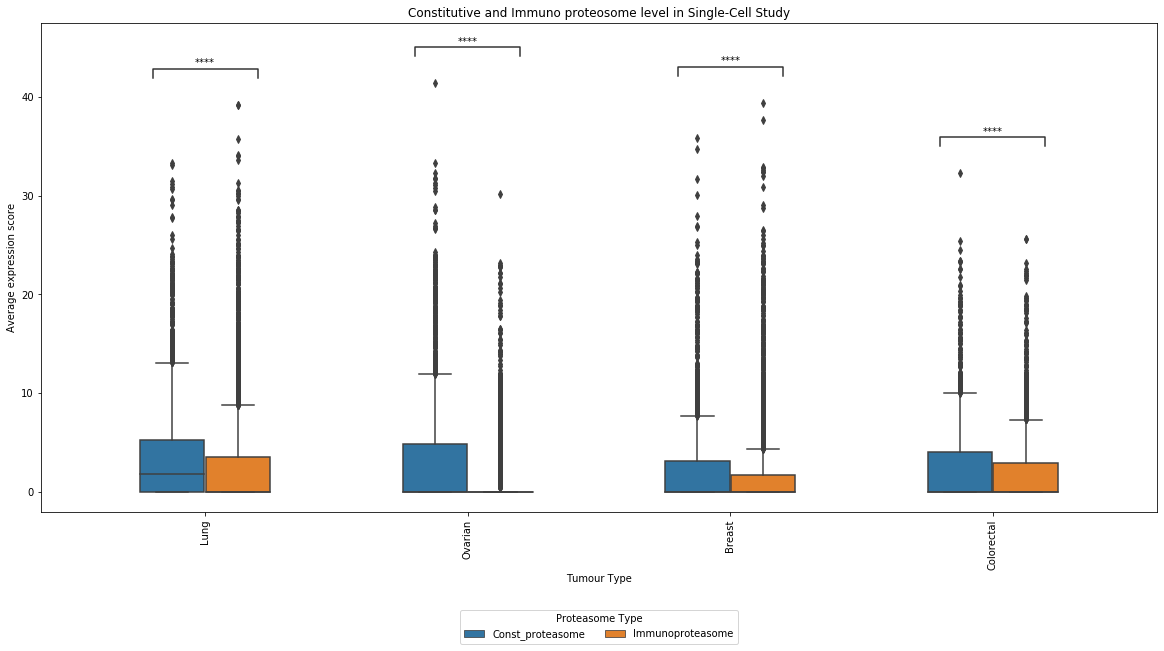

In [298]:
fig, ax=plt.subplots(figsize=(20,9))
res=sns.boxplot(x='Cancer',y='value',hue='variable',data=pst,width=.5,ax=ax)
add_stat_annotation(res, data=pst, x='Cancer',y='value',hue='variable' ,box_pairs=box_pairs,test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
plt.xticks(rotation=90)
plt.title('Constitutive and Immuno proteosome level in Single-Cell Study')
handles, labels = ax.get_legend_handles_labels()
ax.legend( handles=handles, labels=labels,loc='upper center', bbox_to_anchor=(0.5, -0.2),fancybox=True, ncol=5,borderaxespad=0.,title='Proteasome Type')
ax.set_xlabel("Tumour Type")
ax.set_ylabel("Average expression score")
#plt.savefig('SC_pan_avg_proteasome.png',bbox_inches = "tight",dpi=200,format='png')
plt.show()